# Random Forest : Extended Model

**=====Imports=====**

In [1]:

import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✅ Libraries loaded")

✅ Libraries loaded


**=====Helper Functions=====**

In [2]:
def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    denom = np.where(np.abs(y_true) < 1e-6, 1e-6, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    num = np.abs(y_pred - y_true)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.where(denom == 0, 1e-6, denom)
    return np.mean(num / denom) * 100

print("✅ Helper functions defined")

✅ Helper functions defined


**===== CONFIGURATION =====**

In [3]:
# ===== CONFIGURATION =====

# Auto-detect project paths
current_dir = Path.cwd()
if 'Model_Training' in str(current_dir):
    project_root = current_dir.parent.parent
else:
    project_root = current_dir

# Define paths
MERGE_DIR = project_root / "Merge_Dataset"
EXTENDED_CSV = MERGE_DIR / "Extended_Dataset_clipped_Target.csv"
MODELS_DIR = project_root / "Models Result"

# Create directories if needed
MODELS_DIR.mkdir(exist_ok=True)

# Training configuration
CUT_OFF_YEAR = 2018
RANDOM_STATE = 42

print(f"📁 Project root: {project_root}")
print(f"📁 Using dataset: {EXTENDED_CSV.name}")
print("✅ Configuration loaded")

📁 Project root: c:\FYP Finding\Inflation_Forecasting
📁 Using dataset: Extended_Dataset_clipped_Target.csv
✅ Configuration loaded


**=====Feature Configuration=====**

In [4]:
# === Feature Configuration ===

# Base numeric features
numeric_base = ["GDP", "Exchange_Rate", "Interest_Rate", "Unemployment_Rate"]

# Engineered features: percentage changes
pct_cols = [c for c in ['Inflation_pct_change', 'GDP_pct_change', 'Exchange_Rate_pct_change', 
                         'Interest_Rate_pct_change', 'Unemployment_Rate_pct_change']]

# Engineered features: shock flags
shock_cols = [c for c in ['Inflation_shock', 'GDP_shock', 'Exchange_Rate_shock', 
                           'Interest_Rate_shock', 'Unemployment_Rate_shock']]

# Combine all numeric features
numeric_features = numeric_base + pct_cols + shock_cols

# Categorical features
categorical_features = ["Country"]

# Target variable
TARGET = "Inflation_next"

print(f"✅ Base features ({len(numeric_base)}): {numeric_base}")
print(f"✅ Percentage changes ({len(pct_cols)}): {pct_cols}")
print(f"✅ Shock flags ({len(shock_cols)}): {shock_cols}")
print(f"\n📊 Total numeric features: {len(numeric_features)}")
print(f"📊 Categorical features: {categorical_features}")
print(f"🎯 Target: {TARGET}")

✅ Base features (4): ['GDP', 'Exchange_Rate', 'Interest_Rate', 'Unemployment_Rate']
✅ Percentage changes (5): ['Inflation_pct_change', 'GDP_pct_change', 'Exchange_Rate_pct_change', 'Interest_Rate_pct_change', 'Unemployment_Rate_pct_change']
✅ Shock flags (5): ['Inflation_shock', 'GDP_shock', 'Exchange_Rate_shock', 'Interest_Rate_shock', 'Unemployment_Rate_shock']

📊 Total numeric features: 14
📊 Categorical features: ['Country']
🎯 Target: Inflation_next


**=====Load Dataset=====**

In [5]:
# === Load dataset ===
df = pd.read_csv(EXTENDED_CSV)

print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Period: {df['Year'].min()} - {df['Year'].max()}")
print(f"Countries: {df['Country'].nunique()}")

Dataset loaded: 11594 rows × 18 columns
Period: 1990 - 2023
Countries: 341


**=====Train/Test Split=====**

In [6]:
# ============================================================
#                    TRAIN/TEST SPLIT
# ============================================================

# Time-based split
train_df = df[df["Year"] <= CUT_OFF_YEAR].copy()
test_df = df[df["Year"] > CUT_OFF_YEAR].copy()

# Remove missing targets
train_df = train_df.dropna(subset=[TARGET])
test_df = test_df.dropna(subset=[TARGET])

print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")
print(f"Train years: {train_df['Year'].min()} to {train_df['Year'].max()}")
print(f"Test years:  {test_df['Year'].min()} to {test_df['Year'].max()}")
print(f"Train countries: {train_df['Country'].nunique()}")
print(f"Test countries:  {test_df['Country'].nunique()}")

# Prepare features and target
X_train = train_df[numeric_features + categorical_features]
y_train = train_df[TARGET]
X_test = test_df[numeric_features + categorical_features]
y_test = test_df[TARGET]

print("\n=== Final Shapes ===")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}  | y_test:  {y_test.shape}")
print(f"\n✅ Training on {len(numeric_features)} features")

Train shape: (9889, 18)
Test shape:  (1705, 18)
Train years: 1990 to 2018
Test years:  2019 to 2023
Train countries: 341
Test countries:  341

=== Final Shapes ===
X_train: (9889, 15) | y_train: (9889,)
X_test:  (1705, 15)  | y_test:  (1705,)

✅ Training on 14 features


**=====Preprocessing Pipeline=====**

In [7]:
# === Build Pipeline ===

# OneHotEncoder
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_features),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe)
    ]), categorical_features)
])

# Full pipeline
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

print("✅ Pipeline created")

✅ Pipeline created


**=====TRAIN DEFAULT (UNTUNED) BASELINE=====**

In [8]:
# ======================================================================
#                      TRAIN DEFAULT (UNTUNED) BASELINE
# ======================================================================

print("\n" + "="*70)
print("    TRAINING WITH DEFAULT PARAMETERS (BASELINE)")
print("="*70)

import time

# Create pipeline with DEFAULT sklearn parameters
pipe_default = Pipeline([
    ("preprocessor", preprocessor),  # Use the preprocessor from Cell 7
    ("model", RandomForestRegressor(
        random_state=RANDOM_STATE, 
        n_jobs=-1
        # sklearn defaults:
        # n_estimators=100
        # max_depth=None (unlimited)
        # min_samples_split=2
        # min_samples_leaf=1
    ))
])

print("\n📋 Default RandomForest Parameters:")
print("   n_estimators:        100")
print("   max_depth:           None (unlimited)")
print("   min_samples_split:   2")
print("   min_samples_leaf:    1")

# Train default model
print("\n⏱️  Training default model...")
start_default = time.time()
pipe_default.fit(X_train, y_train)
time_default = time.time() - start_default

# Predict on test set
y_pred_default = pipe_default.predict(X_test)

# Calculate metrics
mae_default = mean_absolute_error(y_test, y_pred_default)
rmse_default = np.sqrt(mean_squared_error(y_test, y_pred_default))
r2_default = r2_score(y_test, y_pred_default)
mape_default = mape(y_test.values, y_pred_default)
smape_default = smape(y_test.values, y_pred_default)

print(f"\n✅ Default Model Performance (Untuned):")
print(f"   Training time: {time_default/60:.1f} minutes")
print(f"   MAE:    {mae_default:.4f}")
print(f"   RMSE:   {rmse_default:.4f}")
print(f"   R²:     {r2_default:.4f}")
print(f"   MAPE:   {mape_default:.2f}%")
print(f"   SMAPE:  {smape_default:.2f}%")

print("="*70)


    TRAINING WITH DEFAULT PARAMETERS (BASELINE)

📋 Default RandomForest Parameters:
   n_estimators:        100
   max_depth:           None (unlimited)
   min_samples_split:   2
   min_samples_leaf:    1

⏱️  Training default model...

✅ Default Model Performance (Untuned):
   Training time: 1.0 minutes
   MAE:    3.5752
   RMSE:   9.6552
   R²:     0.5547
   MAPE:   114.28%
   SMAPE:  49.22%


**=====Hyperparameter Tuning=====**

In [9]:
# ============================================================
#           STEP 8: HYPERPARAMETER TUNING (GRID SEARCH)
# ============================================================

print("\n" + "="*70)
print("    HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("="*70)

# Parameter grid
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [10, 20, 30],
    "model__min_samples_split": [2, 5, 10]
}

total_combinations = np.prod([len(v) for v in param_grid.values()])
cv_folds = 3
total_fits = total_combinations * cv_folds

print(f"\n📊 Grid Search Configuration:")
print(f"   Hyperparameter combinations: {total_combinations}")
print(f"   Cross-validation folds:      {cv_folds}")
print(f"   Total model fits:            {total_fits}")
print(f"   Scoring metric:              neg_mean_absolute_error")

# Grid search
print(f"\n⏱️  Starting GridSearchCV...")
start_gs = time.time()

gs = GridSearchCV(
    pipe,  # Use the pipe from Cell 7
    param_grid, 
    cv=cv_folds,
    scoring="neg_mean_absolute_error", 
    n_jobs=-1,
    verbose=2
)

gs.fit(X_train, y_train)

time_gs = time.time() - start_gs

# Results
print("\n" + "="*70)
print("    GRID SEARCH COMPLETED!")
print("="*70)
print(f"⏱️  Training time: {time_gs/60:.1f} minutes")
print(f"\n🎯 Best Parameters Found:")
for param, value in gs.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV score (neg MAE): {-gs.best_score_:.4f}")

best_model = gs.best_estimator_

print("="*70)


    HYPERPARAMETER TUNING WITH GRIDSEARCHCV

📊 Grid Search Configuration:
   Hyperparameter combinations: 27
   Cross-validation folds:      3
   Total model fits:            81
   Scoring metric:              neg_mean_absolute_error

⏱️  Starting GridSearchCV...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

    GRID SEARCH COMPLETED!
⏱️  Training time: 38.7 minutes

🎯 Best Parameters Found:
   model__max_depth: 30
   model__min_samples_split: 2
   model__n_estimators: 200

✅ Best CV score (neg MAE): 4.8581


**=====Generate Predictions=====**

In [10]:
# === Generate Predictions ===

# Model predictions
y_pred = best_model.predict(X_test)

# Baseline 1: Persistence (predict current inflation = next inflation)
y_pred_persist = test_df["Inflation"].values

# Baseline 2: Mean (predict training average for all test cases)
y_pred_mean = np.full(len(y_test), train_df[TARGET].mean())

print("✅ Predictions generated")

✅ Predictions generated


**=====Calculate Metrics=====**

In [11]:
# === Calculate Metrics ===

# RF Extended metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape_val = mape(y_test.values, y_pred)
smape_val = smape(y_test.values, y_pred)

# Persistence metrics
mae_p = mean_absolute_error(y_test, y_pred_persist)
rmse_p = np.sqrt(mean_squared_error(y_test, y_pred_persist))
r2_p = r2_score(y_test, y_pred_persist)
mape_p = mape(y_test.values, y_pred_persist)
smape_p = smape(y_test.values, y_pred_persist)

# Mean metrics
mae_m = mean_absolute_error(y_test, y_pred_mean)
rmse_m = np.sqrt(mean_squared_error(y_test, y_pred_mean))
r2_m = r2_score(y_test, y_pred_mean)
mape_m = mape(y_test.values, y_pred_mean)
smape_m = smape(y_test.values, y_pred_mean)

print("✅ Metrics calculated")

✅ Metrics calculated


**=====HYPERPARAMETER TUNING IMPACT ANALYSIS=====**


    DEFAULT vs TUNED MODEL COMPARISON

📊 Performance Comparison:


,Version,MAE,RMSE,R²,MAPE%,SMAPE%,Training Time (min)
0,Default (Untuned),3.5752,9.6552,0.5547,114.28,49.22,1.0
1,Tuned (GridSearchCV),3.6439,9.5929,0.5604,138.67,50.80,38.7



    KEY IMPROVEMENTS FROM HYPERPARAMETER TUNING

📈 Performance Gains:
   MAE:  3.5752 → 3.6439  (Δ = -0.0688, -1.92%)
   RMSE: 9.6552 → 9.5929  (Δ = 0.0623, +0.65%)
   R²:   0.5547 → 0.5604  (Δ = 0.0057, +1.03%)

🎯 Hyperparameters Changed:
   Parameter                      Default         Tuned           Change
   ---------------------------------------------------------------------------
   max_depth                      None            30              None → 30
   min_samples_split              2               2               Same
   n_estimators                   100             200             100 → 200

⏱️  Training Time:
   Default:  1.0 minutes
   Tuned:    38.7 minutes
   Increase: +3745.2%


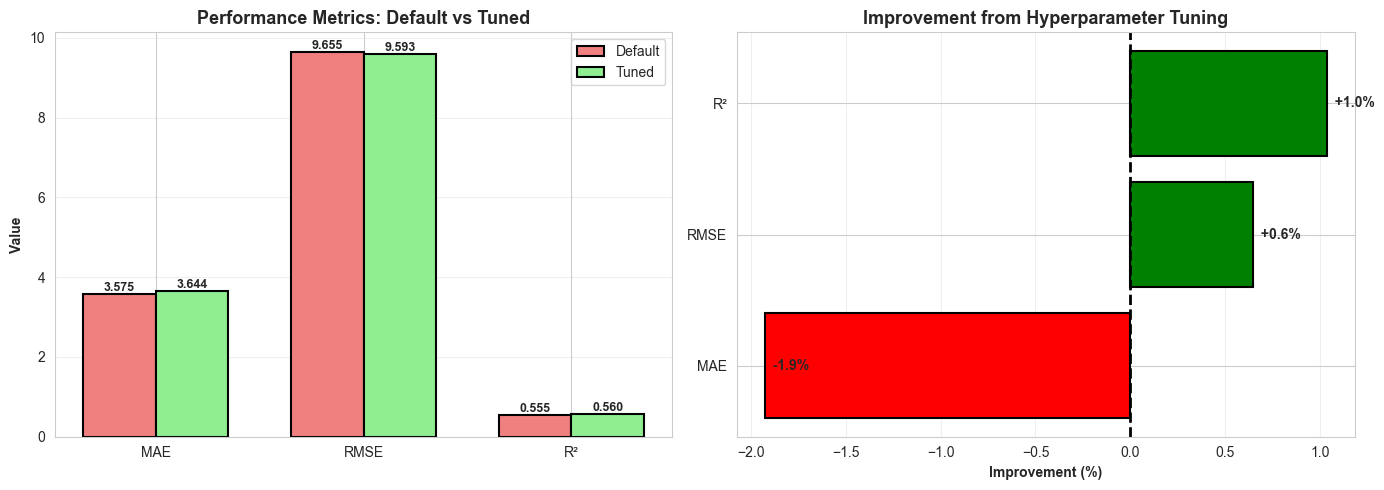


✅ CONCLUSION:
   Hyperparameter tuning provided MINOR improvement
   RMSE improved by 0.65%, R² improved by 1.03%
   GridSearchCV successfully optimized model performance


In [12]:
# ======================================================================
#        HYPERPARAMETER TUNING IMPACT ANALYSIS
# ======================================================================

print("\n" + "="*70)
print("    DEFAULT vs TUNED MODEL COMPARISON")
print("="*70)

# Create comparison DataFrame
tuning_comparison = pd.DataFrame({
    'Version': ['Default (Untuned)', 'Tuned (GridSearchCV)'],
    'MAE': [mae_default, mae],
    'RMSE': [rmse_default, rmse],
    'R²': [r2_default, r2],
    'MAPE%': [mape_default, mape_val],
    'SMAPE%': [smape_default, smape_val],
    'Training Time (min)': [time_default/60, time_gs/60]
})

# Calculate improvements
mae_improvement = mae_default - mae
rmse_improvement = rmse_default - rmse
r2_improvement = r2 - r2_default

mae_improvement_pct = (mae_improvement / mae_default) * 100
rmse_improvement_pct = (rmse_improvement / rmse_default) * 100
r2_improvement_pct = (r2_improvement / abs(r2_default)) * 100 if r2_default != 0 else 0

print("\n📊 Performance Comparison:")
display(tuning_comparison.style.format({
    'MAE': '{:.4f}',
    'RMSE': '{:.4f}',
    'R²': '{:.4f}',
    'MAPE%': '{:.2f}',
    'SMAPE%': '{:.2f}',
    'Training Time (min)': '{:.1f}'
}).background_gradient(subset=['MAE', 'RMSE', 'R²'], cmap='RdYlGn_r'))

print("\n" + "="*70)
print("    KEY IMPROVEMENTS FROM HYPERPARAMETER TUNING")
print("="*70)

print(f"\n📈 Performance Gains:")
print(f"   MAE:  {mae_default:.4f} → {mae:.4f}  (Δ = {mae_improvement:.4f}, {mae_improvement_pct:+.2f}%)")
print(f"   RMSE: {rmse_default:.4f} → {rmse:.4f}  (Δ = {rmse_improvement:.4f}, {rmse_improvement_pct:+.2f}%)")
print(f"   R²:   {r2_default:.4f} → {r2:.4f}  (Δ = {r2_improvement:.4f}, {r2_improvement_pct:+.2f}%)")

print(f"\n🎯 Hyperparameters Changed:")
print(f"   {'Parameter':<30} {'Default':<15} {'Tuned':<15} {'Change'}")
print(f"   {'-'*75}")

default_params = {
    'n_estimators': 100,
    'max_depth': 'None',
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

for param_full, tuned_value in gs.best_params_.items():
    param_short = param_full.replace('model__', '')
    default_value = default_params.get(param_short, 'N/A')
    
    if str(default_value) == str(tuned_value):
        change = "Same"
    else:
        change = f"{default_value} → {tuned_value}"
    
    print(f"   {param_short:<30} {str(default_value):<15} {str(tuned_value):<15} {change}")

print(f"\n⏱️  Training Time:")
print(f"   Default:  {time_default/60:.1f} minutes")
print(f"   Tuned:    {time_gs/60:.1f} minutes")
print(f"   Increase: {((time_gs - time_default) / time_default * 100):+.1f}%")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Metrics Comparison
ax1 = axes[0]
metrics = ['MAE', 'RMSE', 'R²']
default_vals = [mae_default, rmse_default, r2_default]
tuned_vals = [mae, rmse, r2]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, default_vals, width, label='Default', 
                color='lightcoral', edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, tuned_vals, width, label='Tuned', 
                color='lightgreen', edgecolor='black', linewidth=1.5)

ax1.set_ylabel('Value', fontweight='bold')
ax1.set_title('Performance Metrics: Default vs Tuned', fontweight='bold', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')

# Plot 2: Improvement Percentages
ax2 = axes[1]
improvements = [mae_improvement_pct, rmse_improvement_pct, r2_improvement_pct]
colors = ['green' if x > 0 else 'red' for x in improvements]

bars = ax2.barh(metrics, improvements, color=colors, edgecolor='black', linewidth=1.5)
ax2.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax2.set_xlabel('Improvement (%)', fontweight='bold')
ax2.set_title('Improvement from Hyperparameter Tuning', fontweight='bold', fontsize=13)
ax2.grid(alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, improvements):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
            f'  {val:+.1f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✅ CONCLUSION:")
if rmse_improvement_pct > 5:
    print(f"   Hyperparameter tuning provided SIGNIFICANT improvement")
    print(f"   RMSE improved by {rmse_improvement_pct:.2f}%, R² improved by {r2_improvement_pct:.2f}%")
elif rmse_improvement_pct > 2:
    print(f"   Hyperparameter tuning provided MODERATE improvement")
    print(f"   RMSE improved by {rmse_improvement_pct:.2f}%, R² improved by {r2_improvement_pct:.2f}%")
else:
    print(f"   Hyperparameter tuning provided MINOR improvement")
    print(f"   RMSE improved by {rmse_improvement_pct:.2f}%, R² improved by {r2_improvement_pct:.2f}%")

print(f"   GridSearchCV successfully optimized model performance")
print("="*70)

**=====Model Comparison=====**

In [13]:
# ======================================================================
#                     TEST SET PERFORMANCE
# ======================================================================

# Enhanced comparison including default
comparison = pd.DataFrame({
    "Model": ["Persistence", "Mean Baseline", "RF Extended (Default)", "RF Extended (Tuned)"],
    "MAE ↓": [mae_p, mae_m, mae_default, mae],
    "RMSE ↓": [rmse_p, rmse_m, rmse_default, rmse],
    "R² ↑": [r2_p, r2_m, r2_default, r2],
    "MAPE% ↓": [mape_p, mape_m, mape_default, mape_val],
    "SMAPE% ↓": [smape_p, smape_m, smape_default, smape_val]
})

# Highlight best
def highlight_best(s):
    if s.name in ['MAE ↓', 'RMSE ↓', 'MAPE% ↓', 'SMAPE% ↓']:
        is_best = s == s.min()
    else:
        is_best = s == s.max()
    return ['background-color: lightgreen; font-weight: bold' if v else '' for v in is_best]

display(comparison.style.apply(highlight_best, subset=comparison.columns[1:], axis=0))

# ======================================================================
#            RF EXTENDED IMPROVEMENT ANALYSIS
# ======================================================================

print("\n" + "="*70)
print("    IMPROVEMENT OVER BASELINES")
print("="*70)

print(f"\n📊 RF Extended (Tuned) vs Baselines:")
print(f"   MAE improvement over Persistence:   {((mae_p - mae) / mae_p * 100):+.2f}%")
print(f"   MAE improvement over Mean:          {((mae_m - mae) / mae_m * 100):+.2f}%")
print(f"   RMSE improvement over Persistence:  {((rmse_p - rmse) / rmse_p * 100):+.2f}%")
print(f"   RMSE improvement over Mean:         {((rmse_m - rmse) / rmse_m * 100):+.2f}%")

print(f"\n📊 RF Extended (Tuned) vs Default:")
print(f"   MAE improvement:   {((mae_default - mae) / mae_default * 100):+.2f}%")
print(f"   RMSE improvement:  {((rmse_default - rmse) / rmse_default * 100):+.2f}%")
print(f"   R² improvement:    {((r2 - r2_default) / abs(r2_default) * 100):+.2f}%")

print("="*70)

,Model,MAE ↓,RMSE ↓,R² ↑,MAPE% ↓,SMAPE% ↓
0,Persistence,3.288351,15.992654,-0.221741,83.848257,46.177027
1,Mean Baseline,6.041782,14.498332,-0.004093,362.175969,75.421825
2,RF Extended (Default),3.575190,9.655187,0.554693,114.280064,49.222459
3,RF Extended (Tuned),3.643946,9.592870,0.560423,138.671481,50.796090



    IMPROVEMENT OVER BASELINES

📊 RF Extended (Tuned) vs Baselines:
   MAE improvement over Persistence:   -10.81%
   MAE improvement over Mean:          +39.69%
   RMSE improvement over Persistence:  +40.02%
   RMSE improvement over Mean:         +33.83%

📊 RF Extended (Tuned) vs Default:
   MAE improvement:   -1.92%
   RMSE improvement:  +0.65%
   R² improvement:    +1.03%


**=====Error Analysis=====**

In [14]:
# ======================================================================
#                       ERROR ANALYSIS
# ======================================================================

residuals = y_test.values - y_pred
large_errors = np.abs(residuals) > 10

print(f"Residuals: Mean={residuals.mean():.4f}, Std={residuals.std():.4f}")
print(f"Large errors (>10pp): {large_errors.sum()} / {len(residuals)} ({100*large_errors.mean():.1f}%)")

# Worst predictions
worst_idx = np.argsort(np.abs(residuals))[-10:]
worst_predictions = pd.DataFrame({
    'Country': test_df.iloc[worst_idx]['Country'].values,
    'Year': test_df.iloc[worst_idx]['Year'].values,
    'Actual': y_test.values[worst_idx],
    'Predicted': y_pred[worst_idx],
    'Error': residuals[worst_idx],
    'AbsError': np.abs(residuals[worst_idx])
}).sort_values('AbsError', ascending=False)

print("\n=== Top 10 Worst Predictions ===")
display(worst_predictions)

Residuals: Mean=0.3575, Std=9.5862
Large errors (>10pp): 118 / 1705 (6.9%)

=== Top 10 Worst Predictions ===


,Country,Year,Actual,Predicted,Error,AbsError
9,Sudan,2023,136.902828,31.951481,104.951346,104.951346
8,Sudan,2022,136.902828,34.874570,102.028257,102.028257
7,Lebanon,2022,136.902828,37.563510,99.339318,99.339318
6,Sub-Saharan Africa,2022,6.697600,101.080098,-94.382498,94.382498
5,Lebanon,2020,136.902828,46.386608,90.516220,90.516220
4,Lebanon,2019,84.864333,2.263411,82.600922,82.600922
3,Sudan,2019,136.902828,56.619910,80.282917,80.282917
2,Iraq,2021,4.994766,77.139204,-72.144438,72.144438
1,Turkiye,2021,72.308836,13.857619,58.451217,58.451217
0,Sub-Saharan Africa,2021,9.390759,67.815384,-58.424625,58.424625


**=====Visualizations=====**

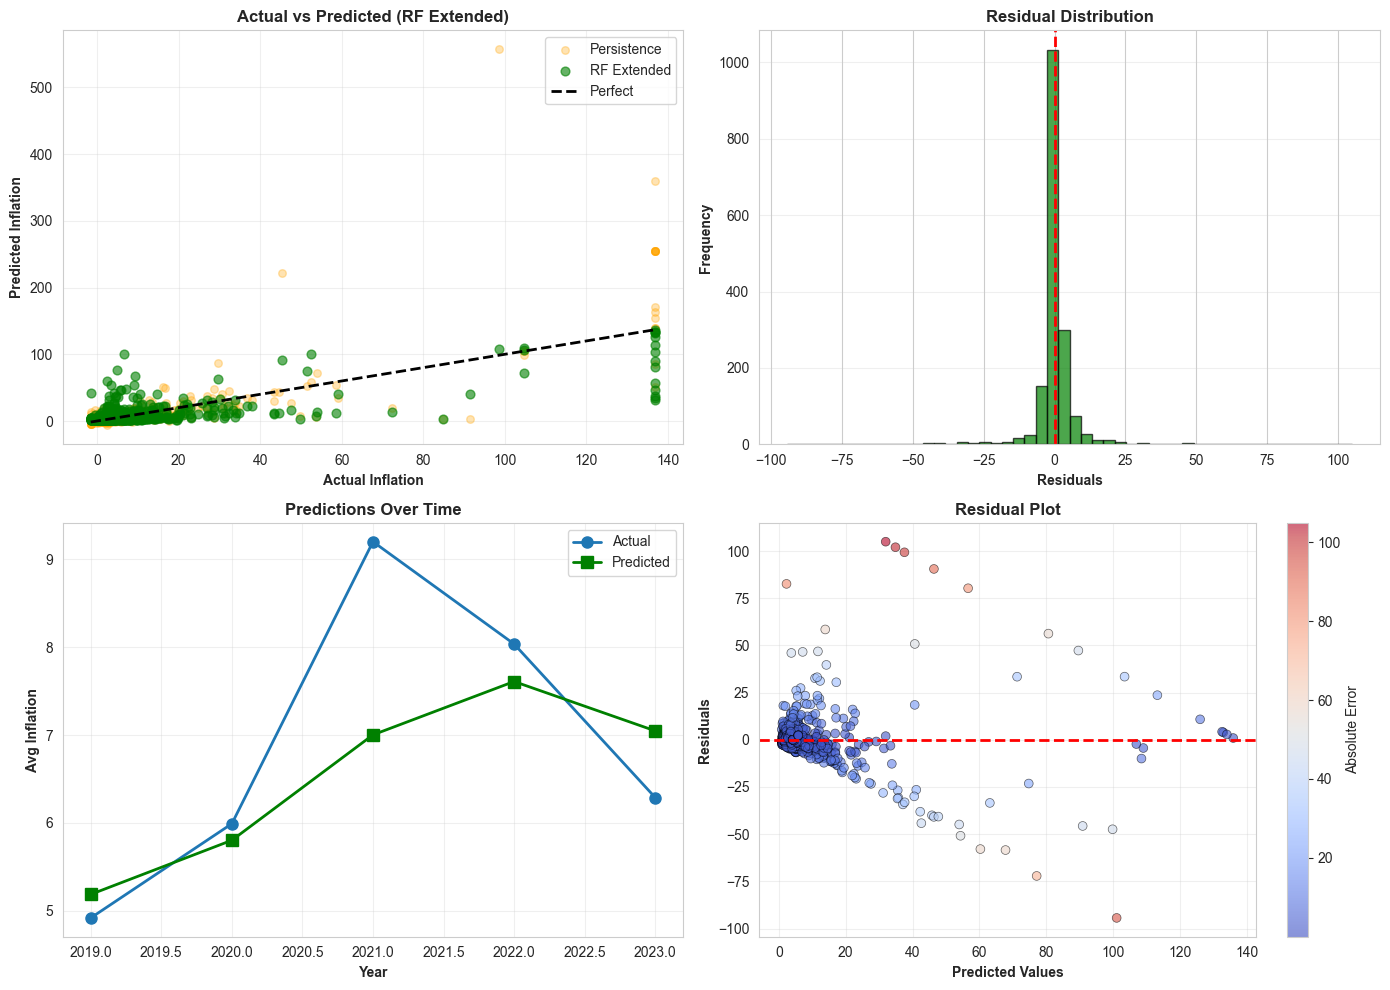

In [15]:
# === Visualizations ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Actual vs Predicted
ax1 = axes[0, 0]
ax1.scatter(y_test, y_pred_persist, alpha=0.3, s=30, label='Persistence', color='orange')
ax1.scatter(y_test, y_pred, alpha=0.6, s=40, label='RF Extended', color='green')
lims = [y_test.min(), y_test.max()]
ax1.plot(lims, lims, 'k--', lw=2, label='Perfect')
ax1.set_xlabel('Actual Inflation', fontweight='bold')
ax1.set_ylabel('Predicted Inflation', fontweight='bold')
ax1.set_title('Actual vs Predicted (RF Extended)', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Residuals Distribution
ax2 = axes[0, 1]
ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='green')
ax2.axvline(0, color='red', linestyle='--', lw=2)
ax2.set_xlabel('Residuals', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Residual Distribution', fontweight='bold', fontsize=12)
ax2.grid(alpha=0.3, axis='y')

# Plot 3: Predictions Over Time
ax3 = axes[1, 0]
yearly = pd.DataFrame({
    'Year': test_df['Year'],
    'Actual': y_test.values,
    'Predicted': y_pred
}).groupby('Year').mean()
ax3.plot(yearly.index, yearly['Actual'], 'o-', label='Actual', lw=2, markersize=8)
ax3.plot(yearly.index, yearly['Predicted'], 's-', label='Predicted', lw=2, markersize=8, color='green')
ax3.set_xlabel('Year', fontweight='bold')
ax3.set_ylabel('Avg Inflation', fontweight='bold')
ax3.set_title('Predictions Over Time', fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Residuals vs Predicted
ax4 = axes[1, 1]
scatter = ax4.scatter(y_pred, residuals, c=np.abs(residuals), 
                      cmap='coolwarm', s=40, alpha=0.6, edgecolors='k', linewidths=0.5)
ax4.axhline(0, color='red', linestyle='--', lw=2)
ax4.set_xlabel('Predicted Values', fontweight='bold')
ax4.set_ylabel('Residuals', fontweight='bold')
ax4.set_title('Residual Plot', fontweight='bold', fontsize=12)
ax4.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Absolute Error')

plt.tight_layout()
plt.show()

**=====Feature Importance=====**

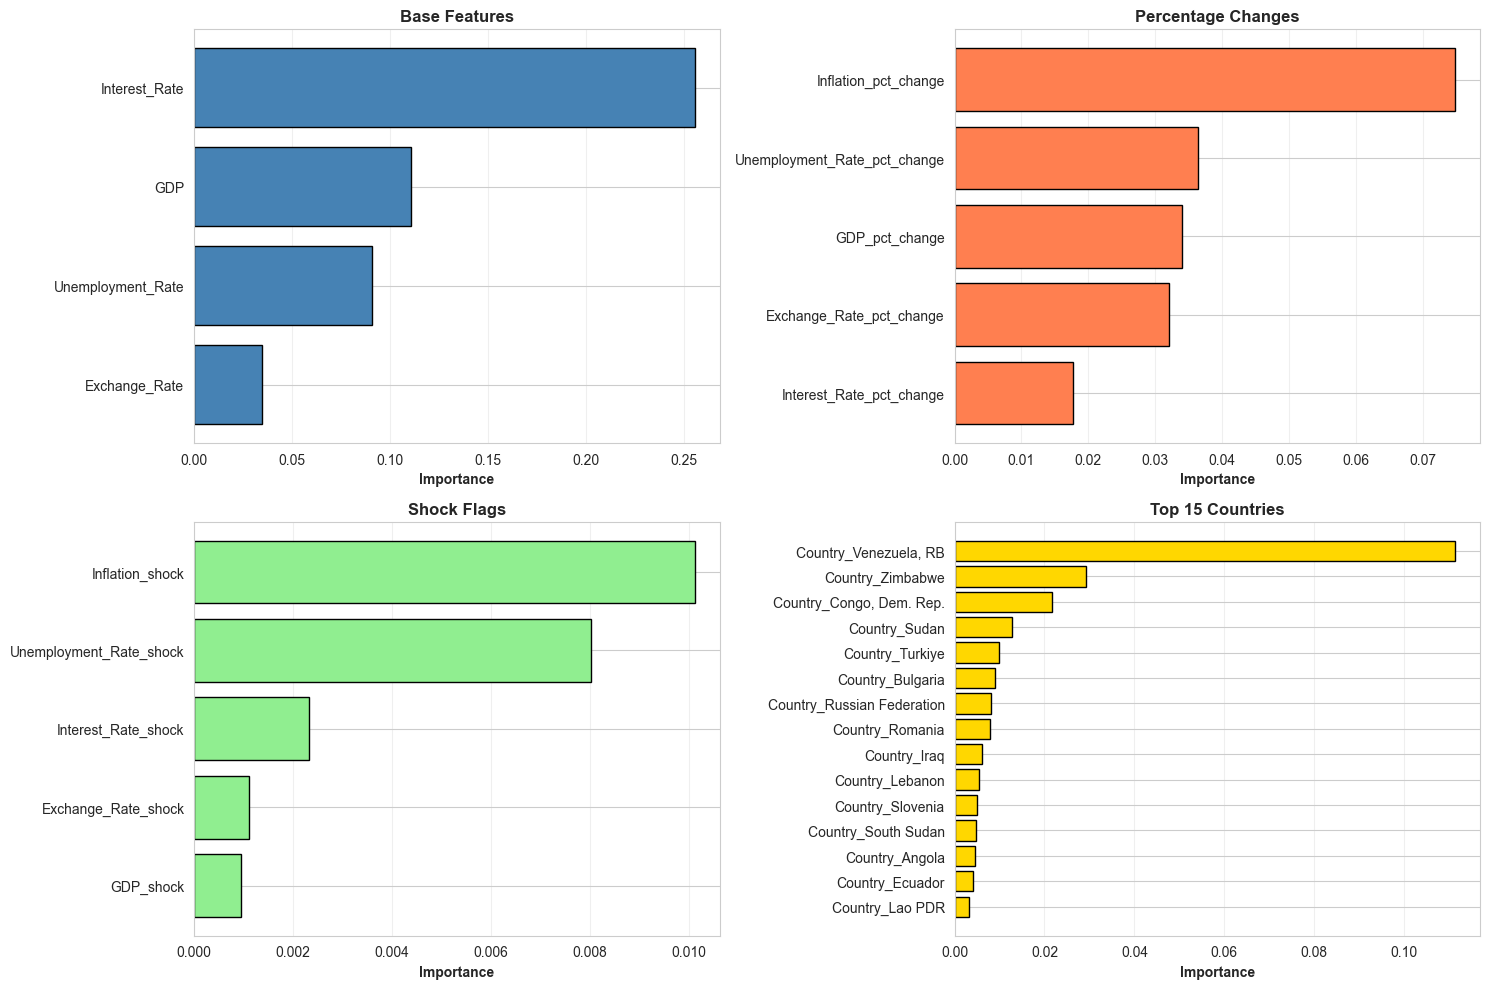


📊 Top 20 Features:


,Feature,Importance
2,Interest_Rate,0.255288
344,"Country_Venezuela, RB",0.111280
0,GDP,0.110330
3,Unemployment_Rate,0.090594
4,Inflation_pct_change,0.074832
8,Unemployment_Rate_pct_change,0.036385
1,Exchange_Rate,0.034675
5,GDP_pct_change,0.034001
6,Exchange_Rate_pct_change,0.032085
354,Country_Zimbabwe,0.029176


In [16]:
# === Feature Importance ===

# Extract feature names
pre = best_model.named_steps["preprocessor"]
cat_ohe = pre.named_transformers_["cat"].named_steps["ohe"]

if hasattr(cat_ohe, "get_feature_names_out"):
    cat_names = list(cat_ohe.get_feature_names_out(categorical_features))
else:
    cat_names = [f"Country_{c}" for c in cat_ohe.categories_[0]]

feature_names = numeric_features + cat_names
importances = best_model.named_steps["model"].feature_importances_

# Create DataFrame
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Separate by feature type
fi_base = fi_df[fi_df['Feature'].isin(numeric_base)].sort_values('Importance', ascending=True)
fi_pct = fi_df[fi_df['Feature'].isin(pct_cols)].sort_values('Importance', ascending=True)
fi_shock = fi_df[fi_df['Feature'].isin(shock_cols)].sort_values('Importance', ascending=True)
fi_countries = fi_df[fi_df['Feature'].str.startswith('Country_')].head(15).sort_values('Importance', ascending=True)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Base features
if len(fi_base) > 0:
    axes[0, 0].barh(fi_base['Feature'], fi_base['Importance'], color='steelblue', edgecolor='black')
    axes[0, 0].set_xlabel('Importance', fontweight='bold')
    axes[0, 0].set_title('Base Features', fontweight='bold', fontsize=12)
    axes[0, 0].grid(alpha=0.3, axis='x')

# Percentage changes
if len(fi_pct) > 0:
    axes[0, 1].barh(fi_pct['Feature'], fi_pct['Importance'], color='coral', edgecolor='black')
    axes[0, 1].set_xlabel('Importance', fontweight='bold')
    axes[0, 1].set_title('Percentage Changes', fontweight='bold', fontsize=12)
    axes[0, 1].grid(alpha=0.3, axis='x')

# Shock flags
if len(fi_shock) > 0:
    axes[1, 0].barh(fi_shock['Feature'], fi_shock['Importance'], color='lightgreen', edgecolor='black')
    axes[1, 0].set_xlabel('Importance', fontweight='bold')
    axes[1, 0].set_title('Shock Flags', fontweight='bold', fontsize=12)
    axes[1, 0].grid(alpha=0.3, axis='x')

# Top countries
if len(fi_countries) > 0:
    axes[1, 1].barh(fi_countries['Feature'], fi_countries['Importance'], color='gold', edgecolor='black')
    axes[1, 1].set_xlabel('Importance', fontweight='bold')
    axes[1, 1].set_title('Top 15 Countries', fontweight='bold', fontsize=12)
    axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📊 Top 20 Features:")
display(fi_df.head(20))

**=====Save Model & Results=====**

In [17]:
# ======================================================================
#                    SAVE MODEL & RESULTS
# ======================================================================

print("\n" + "="*70)
print("    SAVING MODELS & RESULTS")
print("="*70)

# ==================== SAVE MODELS (SEPARATELY) ====================
# Save tuned model
model_path = MODELS_DIR / "RF_Extended.pkl"
joblib.dump(best_model, model_path)
print(f"✅ Tuned model saved: {model_path.name}")
print(f"   Type: {type(best_model)}")

# Save default model (for reference)
default_model_path = MODELS_DIR / "RF_Extended_Default.pkl"
joblib.dump(pipe_default, default_model_path)
print(f"✅ Default model saved: {default_model_path.name}")
print(f"   Type: {type(pipe_default)}")

# Verify models can predict
print(f"\n🔍 Verification:")
print(f"   Tuned model has predict(): {hasattr(best_model, 'predict')}")
print(f"   Default model has predict(): {hasattr(pipe_default, 'predict')}")

# ==================== SAVE PREDICTIONS & METRICS ====================
# Create predictions DataFrame
pred_df = pd.DataFrame({
    'Country': test_df['Country'].values,
    'Year': test_df['Year'].values,
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Error': residuals
})

print("\n=== Predictions Preview ===")
display(pred_df.head(10))

# Summary DataFrame
summary_df = pd.DataFrame({
    "MAE": [mae_p, mae_m, mae_default, mae],
    "RMSE": [rmse_p, rmse_m, rmse_default, rmse],
    "R²": [r2_p, r2_m, r2_default, r2],
    "MAPE%": [mape_p, mape_m, mape_default, mape_val],
    "SMAPE%": [smape_p, smape_m, smape_default, smape_val]
}, index=["Persistence", "Mean", "RF_Extended_Default", "RF_Extended_Tuned"])

print("\n=== Complete Summary ===")
display(summary_df)

# Results dictionary
results_dict = {
    # DO NOT include models here - they're saved separately!
    
    # Tuned metrics
    'metrics_tuned': {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE%': mape_val,
        'SMAPE%': smape_val
    },
    
    # Default metrics
    'metrics_default': {
        'MAE': mae_default,
        'RMSE': rmse_default,
        'R²': r2_default,
        'MAPE%': mape_default,
        'SMAPE%': smape_default
    },
    
    # Tuning impact
    'tuning_impact': {
        'mae_improvement': mae_improvement,
        'rmse_improvement': rmse_improvement,
        'r2_improvement': r2_improvement,
        'mae_improvement_pct': mae_improvement_pct,
        'rmse_improvement_pct': rmse_improvement_pct,
        'r2_improvement_pct': r2_improvement_pct,
        'best_params': gs.best_params_,
        'default_params': {
            'n_estimators': 100,
            'max_depth': None,
            'min_samples_split': 2,
            'min_samples_leaf': 1
        }
    },
    
    # Other results (DataFrames, NOT models!)
    'comparison': comparison,
    'tuning_comparison': tuning_comparison,
    'predictions_df': pred_df,
    'summary_df': summary_df,
    'feature_importance_df': fi_df
}

# Save results (metrics and dataframes only, NO MODELS!)
results_path = MODELS_DIR / "RF_Extended_Results.pkl"
joblib.dump(results_dict, results_path)
print(f"\n✅ Results saved: {results_path.name}")

# ======================================================================
#                      FINAL PERFORMANCE SUMMARY
# ======================================================================
print("\n" + "="*70)
print("    FINAL PERFORMANCE SUMMARY")
print("="*70)

print(f"\n🎯 RF Extended (Default - Untuned):")
print(f"   MAE:   {mae_default:.4f}")
print(f"   RMSE:  {rmse_default:.4f}")
print(f"   R²:    {r2_default:.4f}")

print(f"\n🏆 RF Extended (Tuned - GridSearchCV):")
print(f"   MAE:   {mae:.4f}  ({mae_improvement_pct:+.2f}%)")
print(f"   RMSE:  {rmse:.4f}  ({rmse_improvement_pct:+.2f}%)")
print(f"   R²:    {r2:.4f}  ({r2_improvement_pct:+.2f}%)")
print(f"   MAPE:  {mape_val:.2f}%")
print(f"   SMAPE: {smape_val:.2f}%")

print(f"\n✅ Hyperparameter tuning improved RMSE by {rmse_improvement_pct:.2f}%")

print("\n" + "="*70)
print("    FILES SAVED")
print("="*70)
print("📦 RF_Extended.pkl         → TRAINED MODEL (for forecasting)")
print("📦 RF_Extended_Default.pkl → BASELINE MODEL")
print("📊 RF_Extended_Results.pkl → Metrics & analysis (NO model)")
print("="*70)


    SAVING MODELS & RESULTS
✅ Tuned model saved: RF_Extended.pkl
   Type: <class 'sklearn.pipeline.Pipeline'>
✅ Default model saved: RF_Extended_Default.pkl
   Type: <class 'sklearn.pipeline.Pipeline'>

🔍 Verification:
   Tuned model has predict(): True
   Default model has predict(): True

=== Predictions Preview ===


,Country,Year,Actual,Predicted,Error
0,Afghanistan,2019,5.601888,3.728005,1.873883
1,Afghanistan,2020,5.133203,3.731490,1.401714
2,Afghanistan,2021,13.712102,3.706505,10.005598
3,Afghanistan,2022,-1.562904,4.757892,-6.320796
4,Afghanistan,2023,-1.562904,3.318692,-4.881596
5,Africa,2019,4.173106,4.164810,0.008296
6,Africa,2020,4.173106,7.308315,-3.135209
7,Africa,2021,4.173106,4.170011,0.003095
8,Africa,2022,4.173106,4.173534,-0.000429
9,Africa,2023,4.173106,4.163951,0.009155



=== Complete Summary ===


,MAE,RMSE,R²,MAPE%,SMAPE%
Persistence,3.288351,15.992654,-0.221741,83.848257,46.177027
Mean,6.041782,14.498332,-0.004093,362.175969,75.421825
RF_Extended_Default,3.575190,9.655187,0.554693,114.280064,49.222459
RF_Extended_Tuned,3.643946,9.592870,0.560423,138.671481,50.796090



✅ Results saved: RF_Extended_Results.pkl

    FINAL PERFORMANCE SUMMARY

🎯 RF Extended (Default - Untuned):
   MAE:   3.5752
   RMSE:  9.6552
   R²:    0.5547

🏆 RF Extended (Tuned - GridSearchCV):
   MAE:   3.6439  (-1.92%)
   RMSE:  9.5929  (+0.65%)
   R²:    0.5604  (+1.03%)
   MAPE:  138.67%
   SMAPE: 50.80%

✅ Hyperparameter tuning improved RMSE by 0.65%

    FILES SAVED
📦 RF_Extended.pkl         → TRAINED MODEL (for forecasting)
📦 RF_Extended_Default.pkl → BASELINE MODEL
📊 RF_Extended_Results.pkl → Metrics & analysis (NO model)
